In [1]:
from torch import nn
import torch
import torchvision
from torchvision import transforms
from torchvision.models.resnet import ResNet, Bottleneck, resnet50
from torchvision.models.utils import load_state_dict_from_url
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torchvision.transforms.functional as TF

In [2]:
torch.cuda.is_available()

True

In [3]:
!nvcc --version

/bin/bash: nvcc: command not found


In [4]:
torch.version.cuda

'10.2'

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def convert_to_imshow(tensor):
    if len(tensor.shape) == 1:
        tensor = tensor.reshape(3, 224, 224)
    tensor = torch.from_numpy(tensor)
    std = torch.tensor(normalize.std).view(3, 1, 1)
    mean = torch.tensor(normalize.std).view(3, 1, 1)
    return TF.to_pil_image(torch.clamp(tensor * std + mean, 0, 1))


def load_data(npz_file):
    arr = np.load(npz_file)
    return [arr['arr_0'], arr['arr_1'], arr['arr_2']]

In [6]:
class ResNet50NN(nn.Module):
    
    def __init__(self, k=2, pretrained=True, init_pl=None, **kwargs):
        super().__init__()
        self.backbone = resnet50(pretrained=pretrained)
        self.backbone.fc = nn.Identity()
        
        
        self.pl = nn.Linear(2048, k * 1000)
        if init_pl is not None:
            assert init_pl.shape[1] == 2048
            self.pl.weight.data = init_pl

        self.ml = nn.MaxPool1d(k)

        
    def forward(self, x):
        
        x = self.backbone(x)
        x = self.pl(x)
        x = torch.squeeze(self.ml(x.unsqueeze(0)))
        
        return x

In [7]:
# train_latent = load_data('/home/bethge/ahochlehnert48/results/imc_speckle_1_train_latent.npz')
# val_latent = load_data('/home/bethge/ahochlehnert48/results/imc_speckle_1_val_latent.npz')
train_latent = load_data('/home/bethge/ahochlehnert48/results/imnet_train_latent.npz')
val_latent = load_data('/home/bethge/ahochlehnert48/results/imnet_val_latent.npz')
print(f'Train latent: { sum([train_latent[i].size * train_latent[i].itemsize for i in range(len(train_latent))])/1024**2 } MB')
print(f'Val latent:   { sum([val_latent[i].size * val_latent[i].itemsize for i in range(len(val_latent))])/1024**2 } MB')
print(f'Train latent: { train_latent[0].size * train_latent[0].itemsize/1024**2 } MB')


## simplify labels
train_bird_inds = (train_latent[2] >= 10) * (train_latent[2] <= 24)
train_new_labels = -np.ones_like(train_latent[2])
train_new_labels[train_bird_inds] = 1
train_latent.insert(2, train_new_labels)

print('Difference:', np.sum(train_latent[2]), 'of', np.size(train_latent[2]))

## simplify lables
val_bird_inds = (val_latent[2] >= 10) * (val_latent[2] <= 24)
val_new_labels = -np.ones_like(val_latent[2])
val_new_labels[val_bird_inds] = 1
val_latent.insert(2, val_new_labels)

print('Difference:', np.sum(val_latent[2]), 'of', np.size(val_latent[2]))

Train latent: 29204.3828125 MB
Val latent:   11920.15625 MB
Train latent: 28812.0 MB
Difference: -11176 of 50176
Difference: -18980 of 20480


In [30]:
train_latent[1].nbytes/1024**2

392.0

In [31]:
train_latent[1].shape

(50176, 2048)

In [8]:
def initialise_weights(k):
    def build_init_m(m, k, arr, y):
#         print(arr.shape)
        assert arr.shape[1] == k
        m[:, y*k:y*k + k] = arr
        return m

    df = np.random.uniform(size=[2048, k*1000])

    for y in np.unique(train_latent[3]):
        tmp = train_latent[1][train_latent[3] == y]
        inds = np.random.randint(0, tmp.shape[0], k)
        df = build_init_m(df, k, tmp[inds].T, y)
    
    return df

def get_accuracy(model, loader, cuda=True):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.inference_mode():
        for data in loader:
            images, labels = data
            if cuda:
                images, labels = images.cuda(), labels.cuda()
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [9]:
##
k = 3
# w = torch.Tensor(initialise_weights(k)).T
w=None
model = ResNet50NN(k=k, init_pl=w)

In [10]:
!ls /home/bethge/ahochlehnert48/results/resnet50new/2021-10-22T12:30:45.869594

2021-10-22T12:30:45.869594_0.pth  2021-10-22T12:30:45.869594_6.pth
2021-10-22T12:30:45.869594_1.pth  2021-10-22T12:30:45.869594_7.pth
2021-10-22T12:30:45.869594_2.pth  2021-10-22T12:30:45.869594_8.pth
2021-10-22T12:30:45.869594_3.pth  2021-10-22T12:30:45.869594_9.pth
2021-10-22T12:30:45.869594_4.pth  2021-10-22T12:30:45.869594_final.pth
2021-10-22T12:30:45.869594_5.pth  config.txt


In [11]:
model.load_state_dict(torch.load('/home/bethge/ahochlehnert48/results/resnet50new/2021-10-22T12:30:45.869594/2021-10-22T12:30:45.869594_final.pth'))

<All keys matched successfully>

In [43]:
a = torch.Tensor([
    [1, 4, 6, 2, 7],
    [1, 1, 1, 1, 1],
    [2, 4, 1, 2, 2],
    [0, 1, 0, 0, 0]
])

mp = nn.MaxPool1d(2)
lin = nn.Linear(5, 5)

mp(a)            # <-- works just fine
mp(lin(a))    # <-- returns an error

tensor([[[[4., 6.],
          [4., 2.]]]])

In [7]:
del train_latent
del val_latent

In [12]:
train_dataset = ImageFolder(
    '/mnt/qb/datasets/ImageNet2012/train',
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
)

val_dataset = ImageFolder(
    '/mnt/qb/datasets/ImageNet2012/val',
    transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
)
    
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=2)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64, num_workers=2)

In [15]:
model = resnet50(pretrained=True)
model.eval()
model.cuda()
acc = get_accuracy(model, val_loader)
print(acc)

0.6975


In [13]:
# w = resnet50(pretrained=True).fc.weight.data
# model = ResNet50NN(k=1, init_pl=w)
# model.pl.bias.data = resnet50(pretrained=True).fc.bias.data
model.eval()
model.cuda()
acc = get_accuracy(model, val_loader)
print(acc)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.6717


In [10]:
model = ResNet50NN(k=3)
model.load_state_dict(torch.load('/home/bethge/ahochlehnert48/results/resnet50new/2021-10-14T17:30:34.373000/2021-10-14T17:30:34.373000_final.pth'))

model.eval()
model.cuda()
acc = get_accuracy(model, val_loader)
print(acc)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.6966


In [15]:
res = []
latent_model = resnet50(pretrained=True)
latent_model.fc = nn.Identity()
latent_model.cuda()
model.cuda()
with torch.inference_mode():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()
        latent_out = latent_model(images)
        outputs = model(images)
        
        l = latent_out.cpu().numpy() 
        p = model.pl.weight.cpu().data.numpy()
        r = l @ p.T
        r = r.reshape(labels.size()[0], 1000, k)
        res.append((torch.max(outputs, 1)[1], labels, r))
        break
        latent_out @ model.pl.weights

In [38]:
model.cpu()
l = latent_out.cpu().numpy() 
p = model.pl.weight.data.numpy()

res = l @ p.T
res = res.reshape(64, 1000, 3)

In [29]:
res[0][2]

array([[[-0.62942183, -0.6897932 , -2.0814867 ],
        [-0.9034415 , -0.51100266, -0.56756264],
        [-0.73513305, -0.740977  ,  2.1377606 ],
        ...,
        [-0.9235613 , -0.655033  , -0.6541152 ],
        [-0.28312194,  1.6226017 , -0.41176042],
        [-0.6182491 , -0.5656876 ,  3.0031772 ]],

       [[-0.78212833, -0.7572389 , -1.5377274 ],
        [-0.7076347 , -0.79148096, -0.8200164 ],
        [-0.43358296, -0.57221454, -0.10113978],
        ...,
        [-0.6394353 , -0.4984356 , -0.7108566 ],
        [-0.42628723,  0.6780591 , -0.33182353],
        [-0.3778221 , -0.35615838,  1.9357741 ]],

       [[-0.97259283, -1.033134  , -1.9102578 ],
        [-0.94371665, -2.4190679 , -0.76371825],
        [-1.1210177 , -1.0956354 ,  1.1406479 ],
        ...,
        [-0.8391796 , -2.6297004 , -0.7053219 ],
        [-0.33783278,  1.6278491 , -0.57364786],
        [-0.5220291 , -0.4189089 ,  5.698658  ]],

       ...,

       [[-0.77864134, -0.6435375 , -4.3548193 ],
        [-0

In [29]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

In [ ]:
lrl = []
# print(torch.cuda.memory_summary(device=None, abbreviated=True))
model.cuda()
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    running_accuracy = 0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.cuda(), labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        lrl.append(optimizer.param_groups[0]['lr'])

        # print statistics
        running_loss += loss.item()
        running_accuracy += (torch.sum(torch.argmax(outputs, axis=1) == labels) / outputs.shape[0]).cpu().detach().numpy()
#         print(torch.argmax(outputs, axis=1), labels)
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            print('accuracy', running_accuracy / 10)
            running_loss = 0.0
            running_accuracy = 0
# model.cpu()
print('Finished Training')

In [18]:
from sklearn.neighbors import DistanceMetric

def get_prototype_vec(cls, num):
    assert num >= 0 and num < k
    assert cls >= 0 and cls < model.pl.weight.shape[0]//k
    i = cls*k + num
    return model.pl.weight[i:i+1, :].data.numpy()

# metric = 'cosine'  # 'minkowski'
# dist = DistanceMetric.get_metric(metric)

In [17]:
get_prototype_vec(999, 2).data.numpy()

array([[ 0.01611938,  0.02476782,  0.07092459, ...,  0.00763493,
        -0.02178044,  0.03950567]], dtype=float32)

In [14]:
km = dist.pairwise(train_latent[1], get_prototype_vec(10, 1).detach().numpy())

In [15]:
inds = km.argsort(axis=0).flatten()[:10]

In [71]:
# select demo class
demo_class = 10
k_i = 0

km = np.abs(train_latent[1] @ get_prototype_vec(demo_class, k_i).detach().numpy().T)

# Retrieve class representative
tmp = train_latent[0][train_latent[3] == demo_class]
print(f'{tmp.shape[0]} samples of class "{demo_class}" found')
tmp = tmp[np.random.randint(0, tmp.shape[0]), :, :, :]

1300 samples of class "9" found


1300 samples of class "9" found


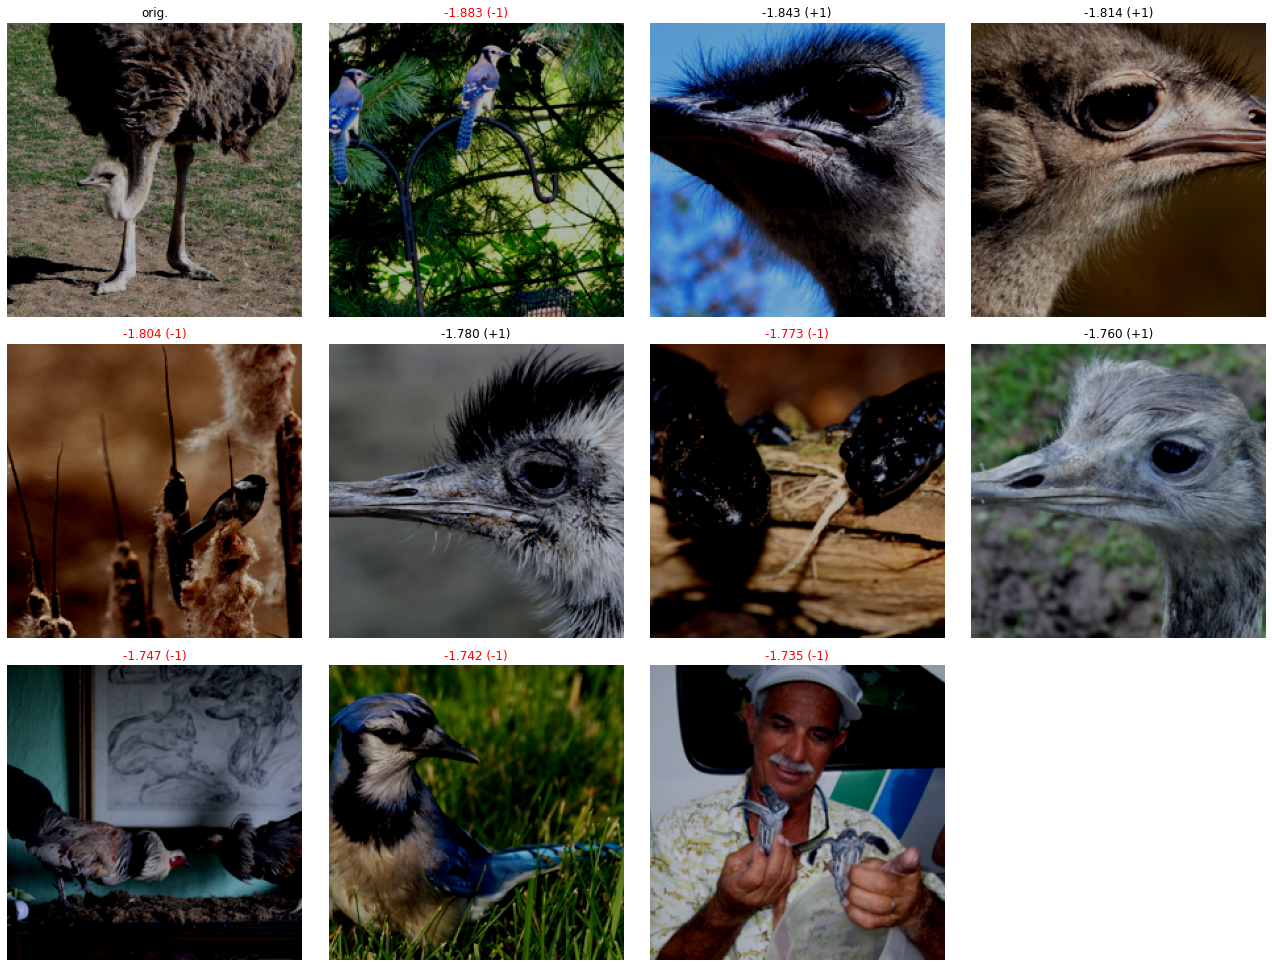

In [65]:
# select demo class
demo_class = 9
k_i = 2

pv = get_prototype_vec(demo_class, k_i)
# km = np.abs(train_latent[1] @ pv.T)
km = train_latent[1] @ pv.T
# km = np.arccos(train_latent[1] @ pv.T / (np.linalg.norm(train_latent[1]) * np.linalg.norm(pv)))
# km = train_latent[1] @ pv.T / (np.linalg.norm(train_latent[1]) * np.linalg.norm(pv))

# Retrieve class representative
tmp = train_latent[0][train_latent[3] == demo_class]
print(f'{tmp.shape[0]} samples of class "{demo_class}" found')
# tmp = tmp[np.random.randint(0, 1), :, :, :]
tmp = tmp[np.random.randint(0, tmp.shape[0]), :, :, :]

inds = km.argsort(axis=0).flatten()[:10]
# inds = np.flip(km.argsort(axis=0).flatten())[:10]

label_flip_len = -1
num_h = len(inds) // 4 + 2
plt.figure(figsize=(18, num_h * 4.5))
# plt.suptitle('KNN')
plt.subplot(num_h, 4, 1); plt.title('orig.'); plt.axis('off')
plt.imshow(convert_to_imshow(tmp))

for i, ind in enumerate(inds):
    plt.subplot(num_h,4,i+2)
    plt.axis('off')
    plt.title(
        "{:.3f} {}".format(km[ind][0], '(+1)' if train_latent[3][ind] == demo_class else '(-1)'), 
        fontdict={ 'color': 'red' if train_latent[3][ind] != demo_class else 'black' })
    plt.imshow(convert_to_imshow(train_latent[0][ind]))
plt.tight_layout()
# plt.savefig(f'{RESULT_DIR}/{dt_id}_readoutvec_{CL}.jpg')
plt.show()

In [106]:
import json
def get_config(path):
    with open(path, 'r') as jf:
        tmp = jf.read()
        tmp = tmp.replace(": <", ": '").replace(">,", "',").replace(">}", "'}").replace(" None", " null").replace("'", '"')
        out = json.loads(tmp)
    del out['_items']['_wandb']
    return out['_items']

def write_config(path, data):
    with open(path, 'w') as jf:
        json.dump(data, jf)
#     out = json.load(jf)

In [116]:
p = '2021-10-01T12:58:09.875379'
pa = f'/home/bethge/ahochlehnert48/results/resnet50new/{p}/config.txt'
data = get_config(pa)
write_config(pa, data)

In [117]:
!cat /home/bethge/ahochlehnert48/results/resnet50new/2021-10-01T12:58:09.875379/config.txt

{"id": "2021-10-01T12:58:09.875379", "learning_rate": 0.001, "momentum": 0.9, "epochs": 10, "log_steps": 100, "k": 3, "weight_decay": 0.0001, "batch_size": 64}